In [1]:
# библиотеки....
import numpy as np 
import pandas as pd 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score 
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


ЧТЕНИЕ И НОРМИРОВАНИЕ ДАННЫХ ИСХОДНОЙ ТАБЛИЦЫ

In [3]:
df = pd.read_csv('/content/drive/My Drive/Bases/makhachkala_weather_2011_2020_2.csv')

In [4]:
# нормируем столбцы (6 столбцов), которые по условию задачи
# участвуют в формировании вектора X
x_cols = ['t_air', 'rel_hum', 'P_atm', 'precip', 'wind_dir', 'wind_speed']

# нормировка данных по каждому столбцу к интервалу [0..1]
for col in x_cols:
  m = max(df[col])
  df[col] = df[col] / m

df

,datetime,t_air,t_soil,t_dew,P_part_water,rel_hum,satur_def,P_atm,precip,wind_dir,wind_speed,shower,snow,fog,strong_wind
0,2011-01-01 00:00:00,0.170984,7.0,5.5,9.01,0.93,0.73,0.970389,0.0,0.833333,0.1875,0,0,0,0
1,2011-01-01 03:00:00,0.160622,6.0,5.1,8.75,0.92,0.73,0.969437,0.0,0.861111,0.2500,0,0,0,0
2,2011-01-01 06:00:00,0.150259,6.0,4.9,8.64,0.94,0.58,0.969723,0.0,0.916667,0.1875,0,0,0,0
3,2011-01-01 09:00:00,0.152850,7.0,3.8,8.00,0.86,1.28,0.969628,0.0,0.861111,0.3750,0,0,0,0
4,2011-01-01 12:00:00,0.134715,6.0,3.0,7.58,0.86,1.26,0.970199,0.0,0.888889,0.3750,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29219,2020-12-31 09:00:00,0.111399,6.0,1.8,7.01,0.84,1.33,0.977625,0.0,0.886111,0.1875,0,0,0,0
29220,2020-12-31 12:00:00,0.121762,6.0,2.4,7.29,0.85,1.29,0.976959,0.0,0.802778,0.1250,0,0,0,0
29221,2020-12-31 15:00:00,0.113990,5.0,2.0,7.09,0.85,1.25,0.976673,0.0,0.905556,0.0625,0,0,1,0
29222,2020-12-31 18:00:00,0.119171,2.0,2.0,7.07,0.83,1.45,0.980577,0.0,0.433333,0.1875,0,0,0,0


ФУНКЦИЯ ГЕНЕРАЦИИ ВЫБОРКИ 

In [5]:
# data - исходный датафрейм
# days_count - размер блока данных для X примера (по умолчанию 1 день)
# x_col_names - список колонок c которых генерируются векторы X
# y_col_name - колонка для генерации значений Y

def CreateSamples(data, x_col_names, y_col_name, days_count=1):
  
  block_size = days_count * 8 # размер блока данных

  pos = 0 # начальная позиция текущего смещения в датасете

  # обнуляем списки...
  samples_x = []
  samples_y = []
  
  Ex = False

  while not Ex: # цикл остановится, когда переменная Ex станет истиной 

    if pos + block_size < data.shape[0]: # если не дошли до конца....

      x_vec = []
      for x_col_name in x_col_names:
        x_vec.extend(data[x_col_name][pos:pos+block_size].to_list())
      
      y_vec = data[y_col_name][pos+block_size:pos+block_size+1].to_list()   

      samples_x.append(x_vec)
      samples_y.append(y_vec)

    else:

      Ex = True
    
    pos += 1 # сдвигаем позицию на 1

  # перевод данных в numpy массивы
  samples_x = np.array(samples_x)
  samples_y = np.array(samples_y).astype('float')

  return samples_x, samples_y


ГЕНЕРАЦИЯ ВЫБОРКИ

In [6]:
# размер блока данных
days_count = 7

# генерация выборки 
samples_x, samples_y = CreateSamples(df, x_cols, 'fog', days_count)

# рамерность массивов
print(samples_x.shape)
print(samples_y.shape)

(29168, 336)
(29168, 1)


МОДЕЛЬ НЕЙРОННОЙ СЕТИ (только полносвязные слои)

In [8]:
# days_count - размер блока данных в днях

def CreateModel(days_count, activation='linear', dropout=0.1):

  input = Input((days_count*8*6,))
  
  x = BatchNormalization()(input)
  x = Dense(1000, activation=activation)(x)
  x = Dropout(dropout)(x)

  x = BatchNormalization()(x)
  x = Dense(500, activation=activation)(x)
  x = Dropout(dropout)(x)
  
  x = BatchNormalization()(x)
  x = Dense(200, activation=activation)(x)
  x = Dropout(dropout)(x)

  x = BatchNormalization()(x)
  x = Dense(100, activation=activation)(x)
  x = Dropout(dropout)(x)

  output = Dense(1, activation='sigmoid')(x) 

  return Model(input, output) 

CALLBACK для фиксации лучшего обучения по метрике RECALL

In [9]:
# файл для сохранения лучших весов модели
model_save_file = '/content/drive/My Drive/Bases/model_best_f_d.h5'

# собственный коллбэк
class MyCallback(Callback):
  
  # инициализация
  def __init__(self, model, x_val, y_val):
    # модель
    self.model = model 
    # проверочная выборка
    self.x_val = x_val 
    self.y_val = y_val
    # начальный счет по средней метрике
    self.score = 0
    # список значений по метрике Recall
    self.recall_list = []
    # список значений по средней метрике
    self.general_list = []
       
  # подсчет метрики Recall для val  
  def calc_metric(self):
    y_pred = self.model.predict(self.x_val)
    y_p = np.around(y_pred).astype(int)
    y_t = np.around(self.y_val).astype(int)
    rec = recall_score(y_t, y_p, average='macro')
    acc = accuracy_score(y_t, y_p)
    return rec, acc
  
  # окончение каждой эпохи....
  def on_epoch_end(self, epoch, logs=None):
    rec, acc = self.calc_metric()
    self.recall_list.append(rec)
    score_0 = (rec + acc)/2
    self.general_list.append(score_0)
    print('\n\nТекущая точность (Recall+Accuracy)/2 =', score_0, '\n')
    if score_0 > self.score:
      self.score = score_0
      print('\n\n!!!!!!!!ЛУЧШАЯ ТОЧНОСТЬ (RECALL+ACCURACY)/2 =', score_0, '\n')
      self.model.save_weights(model_save_file)   

  # в конце обучения
  def on_train_end(self, logs=None):
    print('\n\n!!!!!!!!ЛУЧШАЯ ТОЧНОСТЬ (RECALL+ACCURACY)/2 ОБУЧЕНИЯ =', self.score, '\n')
  
  # получение списка recall_list
  def get_recall_list(self):
    return self.recall_list

  # получение списка general_list
  def get_general_list(self):
    return self.general_list  

ПАРАМЕТРЫ ОБУЧЕНИЯ

In [10]:
# параметры обучения

batch_size = 50

dropout = 0.25

activate_function = 'relu'

epochs_count = 50

learning_rate = 1e-4

ОБУЧЕНИЕ НЕЙРОННОЙ СЕТИ

In [11]:
# деление выборки на обучающую и проверочную
x_train, x_val, y_train, y_val = train_test_split(samples_x, samples_y, 
                                                  test_size=0.1, random_state=1)

In [12]:
# настройка весов для классов модели (учет разбаллансировки)
weight_for_0 = 1.0 / (y_train == 0.0).sum()
weight_for_1 = 1.0 / (y_train == 1.0).sum()

class_weight = {0: weight_for_0, 1: weight_for_1}

print(class_weight)

{0: 3.852080123266564e-05, 1: 0.003436426116838488}


In [13]:
# создание модели
model = CreateModel(days_count=days_count, 
                    activation=activate_function, dropout=dropout)  
cb = MyCallback(model, x_val, y_val)

In [14]:
# компиляция
model.compile(optimizer=Adam(learning_rate=learning_rate), 
              loss=['binary_crossentropy'], 
              metrics=['accuracy'])

# обучение
history = model.fit(x_train, y_train, 
                    batch_size = batch_size,
                    epochs= epochs_count, 
                    validation_data=(x_val, y_val), 
                    verbose=1, 
                    class_weight = class_weight,
                    callbacks=[cb])

Epoch 1/50
92/92 [==============================] - 0s 2ms/step


Текущая точность (Recall+Accuracy)/2 = 0.6087425566991362 



!!!!!!!!ЛУЧШАЯ ТОЧНОСТЬ (RECALL+ACCURACY)/2 = 0.6087425566991362 

526/526 [==============================] - 7s 7ms/step - loss: 5.1271e-05 - accuracy: 0.4955 - val_loss: 0.8053 - val_accuracy: 0.4967
Epoch 2/50
92/92 [==============================] - 0s 2ms/step


Текущая точность (Recall+Accuracy)/2 = 0.6955774127769356 



!!!!!!!!ЛУЧШАЯ ТОЧНОСТЬ (RECALL+ACCURACY)/2 = 0.6955774127769356 

526/526 [==============================] - 3s 6ms/step - loss: 4.2638e-05 - accuracy: 0.6287 - val_loss: 0.5461 - val_accuracy: 0.6678
Epoch 3/50
92/92 [==============================] - 0s 2ms/step


Текущая точность (Recall+Accuracy)/2 = 0.7114047876629446 



!!!!!!!!ЛУЧШАЯ ТОЧНОСТЬ (RECALL+ACCURACY)/2 = 0.7114047876629446 

526/526 [==============================] - 3s 6ms/step - loss: 3.8462e-05 - accuracy: 0.6967 - val_loss: 0.5443 - val_accuracy: 0.6808
Epoch 4/50

АРХИТЕКТУРА МОДЕЛИ

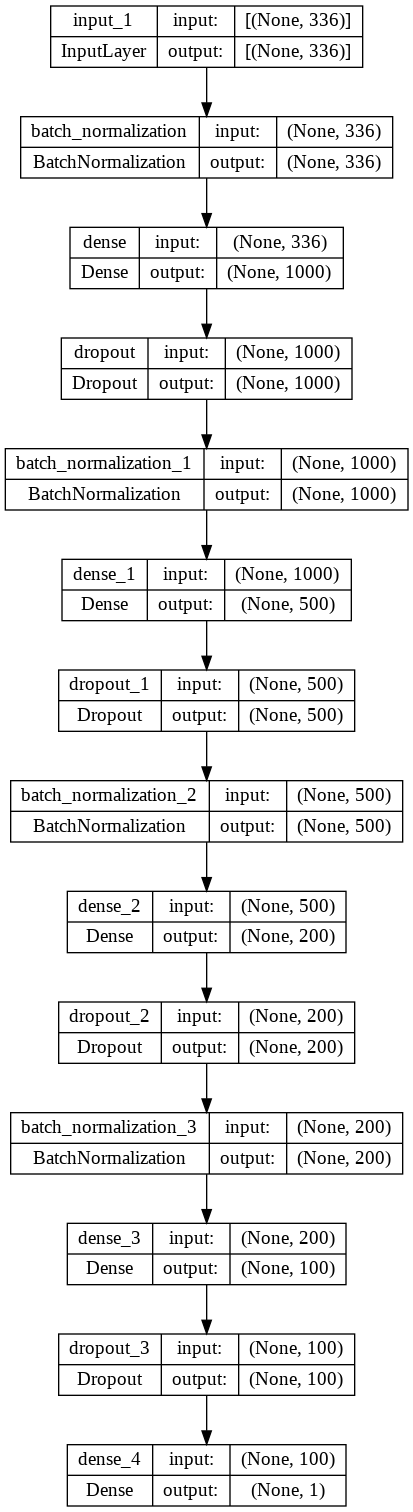

In [15]:
plot_model(model, show_shapes=True, show_layer_names=True)

ГРАФИКИ ОБУЧЕНИЯ

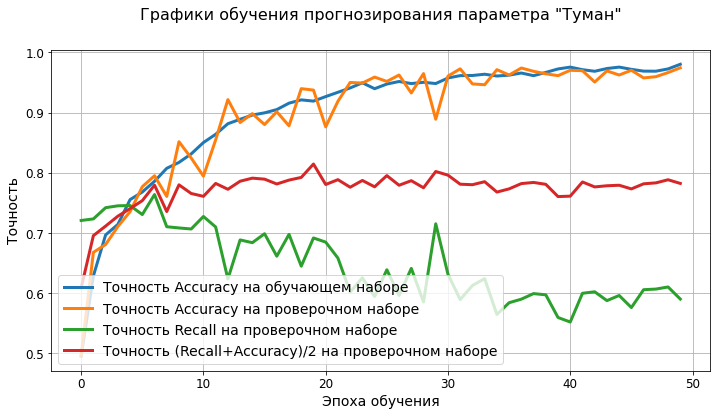

In [16]:
# графики обучения
def cm_to_inch(value):
    return value/2.54

plt.figure(figsize=(cm_to_inch(30),cm_to_inch(15)))

plt.title('Графики обучения прогнозирования параметра "Туман"', 
          pad=30, fontsize=16)

plt.plot(history.history['accuracy'], 
         label='Точность Accuracy на обучающем наборе', linewidth=3)
plt.plot(history.history['val_accuracy'], 
         label='Точность Accuracy на проверочном наборе', linewidth=3)
plt.plot(cb.get_recall_list(), 
         label='Точность Recall на проверочном наборе', linewidth=3)
plt.plot(cb.get_general_list(), 
         label='Точность (Recall+Accuracy)/2 на проверочном наборе', linewidth=3)

plt.xlabel('Эпоха обучения', fontsize=14)
plt.ylabel('Точность', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()